In [1]:
import os
from glob import glob

import fitsio
from fitsio import FITS
from astropy.io import ascii
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from cycler import cycler
plt.rcParams.update({
    'figure.figsize'   : (12, 10),
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   : 5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 7,
    'ytick.major.size' : 7,
    'xtick.major.width': 3,
    'ytick.major.width': 3,
    'xtick.minor.size' : 5,
    'ytick.minor.size' : 5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'lines.linewidth'  : 3,
    'axes.prop_cycle'  : cycler('color', ['red', 'orange', 'teal', 'skyblue']),
})

def Table_to_array(table):
    tuple_data = table.as_array()
    list_data  = [list(values) for values in tuple_data]
    array_data = np.array(list_data, dtype = np.float32)

    return array_data

def normalized_arrays(x_values, y_values):
    dx = x_values[1:] - x_values[:-1]
    norm_factor = np.sum(y_values[:-1] * dx)
    norm_y_values = y_values/norm_factor
    return x_values, norm_y_values

In [ ]:
KiDS_predicted = FITS('/data2/lsajkov/mpdg/saved_soms/08Aug24_no_mag_cut/predicted_catalog.fits')
KiDS_panchrom  = FITS('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_07Aug24.fits')[1]
# with fits.open('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_SOM_r50_01Aug24.fits') as cat:
#     KiDS_predicted = Table(cat[1].data)

In [15]:
folder = '/data2/lsajkov/mpdg/saved_soms/12Aug24_mag_cut_20p5_no_z'

KiDS_predicted = FITS(f'{folder}/predicted_catalog.fits')

labeled_map = np.load(f'{folder}/labeled_map_from_dist.npy',
                      allow_pickle = True)
labeled_map_l68 = np.load(f'{folder}/labeled_map_l68.npy',
                      allow_pickle = True)
labeled_map_u68 = np.load(f'{folder}/labeled_map_u68.npy',
                      allow_pickle = True)
# labeled_map_values = np.load(f'{folder}/labeled_map_values.npy',
#                       allow_pickle = True)
data_bmus = np.load(f'{folder}/data_bmus.npy',
                      allow_pickle = True)
labeling_bmus = np.load(f'{folder}/labeling_bmus.npy',
                      allow_pickle = True)

In [3]:
mstar_lo = labeled_map[..., 1] < 8.75
mstar_md = (labeled_map[..., 1] >= 8.75) & (labeled_map[..., 1] < 9.5)
mstar_hi = labeled_map[..., 1] >= 9.5

In [6]:
#Visualize labeled SOM
n_rows = 48
n_columns = 48


hexmesh = np.meshgrid(np.linspace(0, n_rows - 1, n_rows),
                      np.linspace(0, n_columns - 1, n_columns))

hexmesh[0][1::2] += 1/2

hex_mstar_lo = [hexmesh[0][mstar_lo],
                hexmesh[1][mstar_lo]]

hex_mstar_md = [hexmesh[0][mstar_md],
                hexmesh[1][mstar_md]]

hex_mstar_hi = [hexmesh[0][mstar_hi],
                hexmesh[1][mstar_hi]]

In [ ]:
selected_cell = [hex_mstar_lo[0][5], hex_mstar_lo[1][5]]

In [71]:
selected_cell = [32, 38]

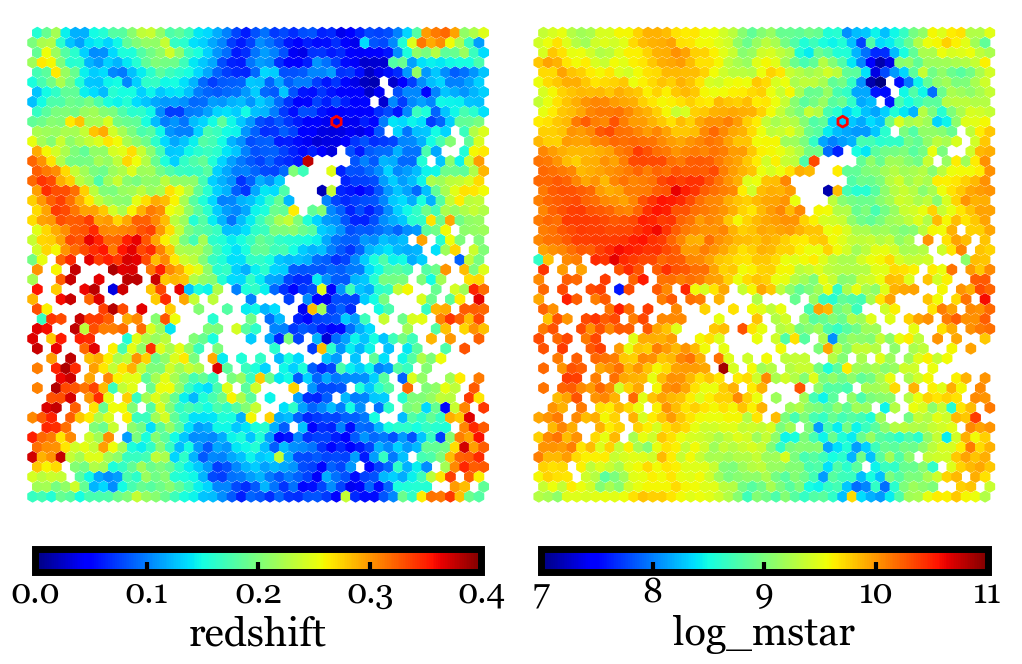

In [72]:
fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)

for i in range(2):
    ax = fig.add_subplot(1, 5, i + 1)

    if i == 0:
        vmin = 0; vmax = 0.4
    if i == 1:
        vmin = 7; vmax = 11
    map = ax.scatter(*hexmesh, c = labeled_map[..., i], marker = 'h', cmap = 'jet', s = 60,
                     vmin = vmin, vmax = vmax)
    ax.axis('off')

    # ax.scatter(*hex_mstar_lo, marker = 'h', s = 60,
    #            facecolor = 'none', edgecolor = 'blue', linewidth = 1)
    
    # ax.scatter(*hex_mstar_md, marker = 'h', s = 60,
    #            facecolor = 'none', edgecolor = 'orange', linewidth = 1)

    ax.scatter(*selected_cell, marker = 'h', s = 60,
               facecolor = 'none', edgecolor = 'red', linewidth = 2)    
    # ax.scatter(*hex_mstar_hi, marker = 'h', s = 60,
    #            facecolor = 'none', edgecolor = 'red', linewidth = 3)

    fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = ['redshift', 'log_mstar'][i], shrink = 0.9)

In [ ]:
images_path = '/disks/shear15/KiDS/KiDS-1000/Awe/images'

In [ ]:
KiDS_predicted[1][0]

In [ ]:
u_image = FITS('/disks/shear15/KiDS/KiDS-1000/Awe/images/KIDS_4.7_-32.1_u_sci.fits')
g_image = FITS('/disks/shear15/KiDS/KiDS-1000/Awe/images/KIDS_4.7_-32.1_g_sci.fits')
r_image = FITS('/disks/shear15/KiDS/KiDS-1000/Awe/images/KIDS_4.7_-32.1_r_sci.fits')
i_image = FITS('/disks/shear15/KiDS/KiDS-1000/Awe/images/KIDS_4.7_-32.1_i_sci.fits')

In [8]:
def get_cutout_in_band(ra0, dec0, size,
                       fits_object):

    size = size.to(u.deg)

    header = fits_object[0].read_header()
    wcs = WCS(header)

    delta_dec = size/2
    dec_lo = dec0 - delta_dec
    dec_hi = dec0 + delta_dec

    ra_lo = ra0 - size/2/np.cos(dec0 + delta_dec/2)
    ra_hi = ra0 + size/2/np.cos(dec0 - delta_dec/2)

    lower_left  = SkyCoord(ra_lo, dec_lo)
    upper_right = SkyCoord(ra_hi, dec_hi)
 
    lower_left_idx  = list(wcs.world_to_array_index(lower_left))
    upper_right_idx = list(wcs.world_to_array_index(upper_right))

    return fits_object[0][lower_left_idx[0]:upper_right_idx[0],
                          upper_right_idx[1]:lower_left_idx[1]]

In [9]:
KiDS_predicted[1]['KiDS_tile'][0]


'KIDS_229.0_-0.5'

In [ ]:
g_image = FITS(f'/disks/shear15/KiDS/KiDS-1000/Awe/images/KIDS_229.0_-0.5_g_sci.fits')

In [ ]:
g_image[0][0::50,0::50].std()

In [10]:
def get_rgb_cutout(ra, dec, tile, size,
                   Q = 2, stretch = 1.5):

    g_image = FITS(f'/disks/shear15/KiDS/KiDS-1000/Awe/images/{tile}_g_sci.fits')
    r_image = FITS(f'/disks/shear15/KiDS/KiDS-1000/Awe/images/{tile}_r_sci.fits')
    i_image = FITS(f'/disks/shear15/KiDS/KiDS-1000/Awe/images/{tile}_i_sci.fits')

    g_cutout = get_cutout_in_band(ra, dec, size,
                                  g_image)
    r_cutout = get_cutout_in_band(ra, dec, size,
                                  r_image)
    i_cutout = get_cutout_in_band(ra, dec, size,
                                  i_image)
    
    g_cutout /= g_image[0][::50,::50].std()
    r_cutout /= r_image[0][::50,::50].std()
    i_cutout /= i_image[0][::50,::50].std()

    # g_cutout /= g_cutout.std()
    # r_cutout /= r_cutout.std()
    # i_cutout /= i_cutout.std()
    
    rgb_cutout = make_lupton_rgb(i_cutout, r_cutout, g_cutout,
                             Q = Q, stretch = stretch)
    
    return rgb_cutout

In [14]:
data_bmus

array(None, dtype=object)

In [75]:
def get_images_from_cell(cell, gridsize, Q = 2, stretch = 1.5,
                         cutout_size = 15 * u.arcsec):

    source_idx = np.arange(0, KiDS_predicted[1].get_nrows())
    source_idx = source_idx[np.all(data_bmus == cell[::-1], axis = 1)]

    sources_in_cell = KiDS_predicted[1][source_idx]

    sources_to_display = np.random.choice(sources_in_cell, size = np.prod(gridsize), replace = False)

    fig = plt.figure(figsize = (20, 20))

    for i, source in enumerate(sources_to_display):

        ax = fig.add_subplot(*gridsize, i + 1)

        source_cutout = get_rgb_cutout(source['ra'] * u.deg, source['dec'] * u.deg, source['KiDS_tile'],
                                    cutout_size, Q = Q, stretch = stretch)
        
        ax.imshow(source_cutout, origin = 'lower')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.05, 0.9, f'$z \sim {sources_in_cell["redshift_pred"][0]:.2f}$', color = 'white', fontsize = 72,
                transform = ax.transAxes)
        ax.text(0.260, 0.9, f'$-{sources_in_cell["redshift_pred_l68"][0]:.2f}$', color = 'white', fontsize = 36,
                transform = ax.transAxes)
        ax.text(0.260, 0.925, f'$+{sources_in_cell["redshift_pred_u68"][0]:.2f}$', color = 'white', fontsize = 36,
                transform = ax.transAxes)

        ax.text(0.05, 0.84, f'$M \sim {sources_in_cell["mstar_pred"][0]:.2f}$', color = 'white', fontsize = 72,
                transform = ax.transAxes)
        ax.text(0.285, 0.84, f'$-{sources_in_cell["mstar_pred_l68"][0]:.2f}$', color = 'white', fontsize = 36,
                transform = ax.transAxes)
        ax.text(0.285, 0.865, f'$+{sources_in_cell["mstar_pred_u68"][0]:.2f}$', color = 'white', fontsize = 36,
                transform = ax.transAxes)

    print(f'Values for sources in cell:\nRedshift {sources_in_cell['redshift_pred'][0]}\nM* {sources_in_cell['mstar_pred'][0]}')

    fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
    fig.show()


<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/var/tmp/lsajkov/ipykernel_2449758/2772467843.py:23: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.05, 0.9, f'$z \sim {sources_in_cell["redshift_pred"][0]:.2f}$', color = 'white', fontsize = 72,
/var/tmp/lsajkov/ipykernel_2449758/2772467843.py:30: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.05, 0.84, f'$M \sim {sources_in_cell["mstar_pred"][0]:.2f}$', color = 'white', fontsize = 72,


Values for sources in cell:
Redshift 0.03855421686746988
M* 8.289156626506024


/var/tmp/lsajkov/ipykernel_2449758/2772467843.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


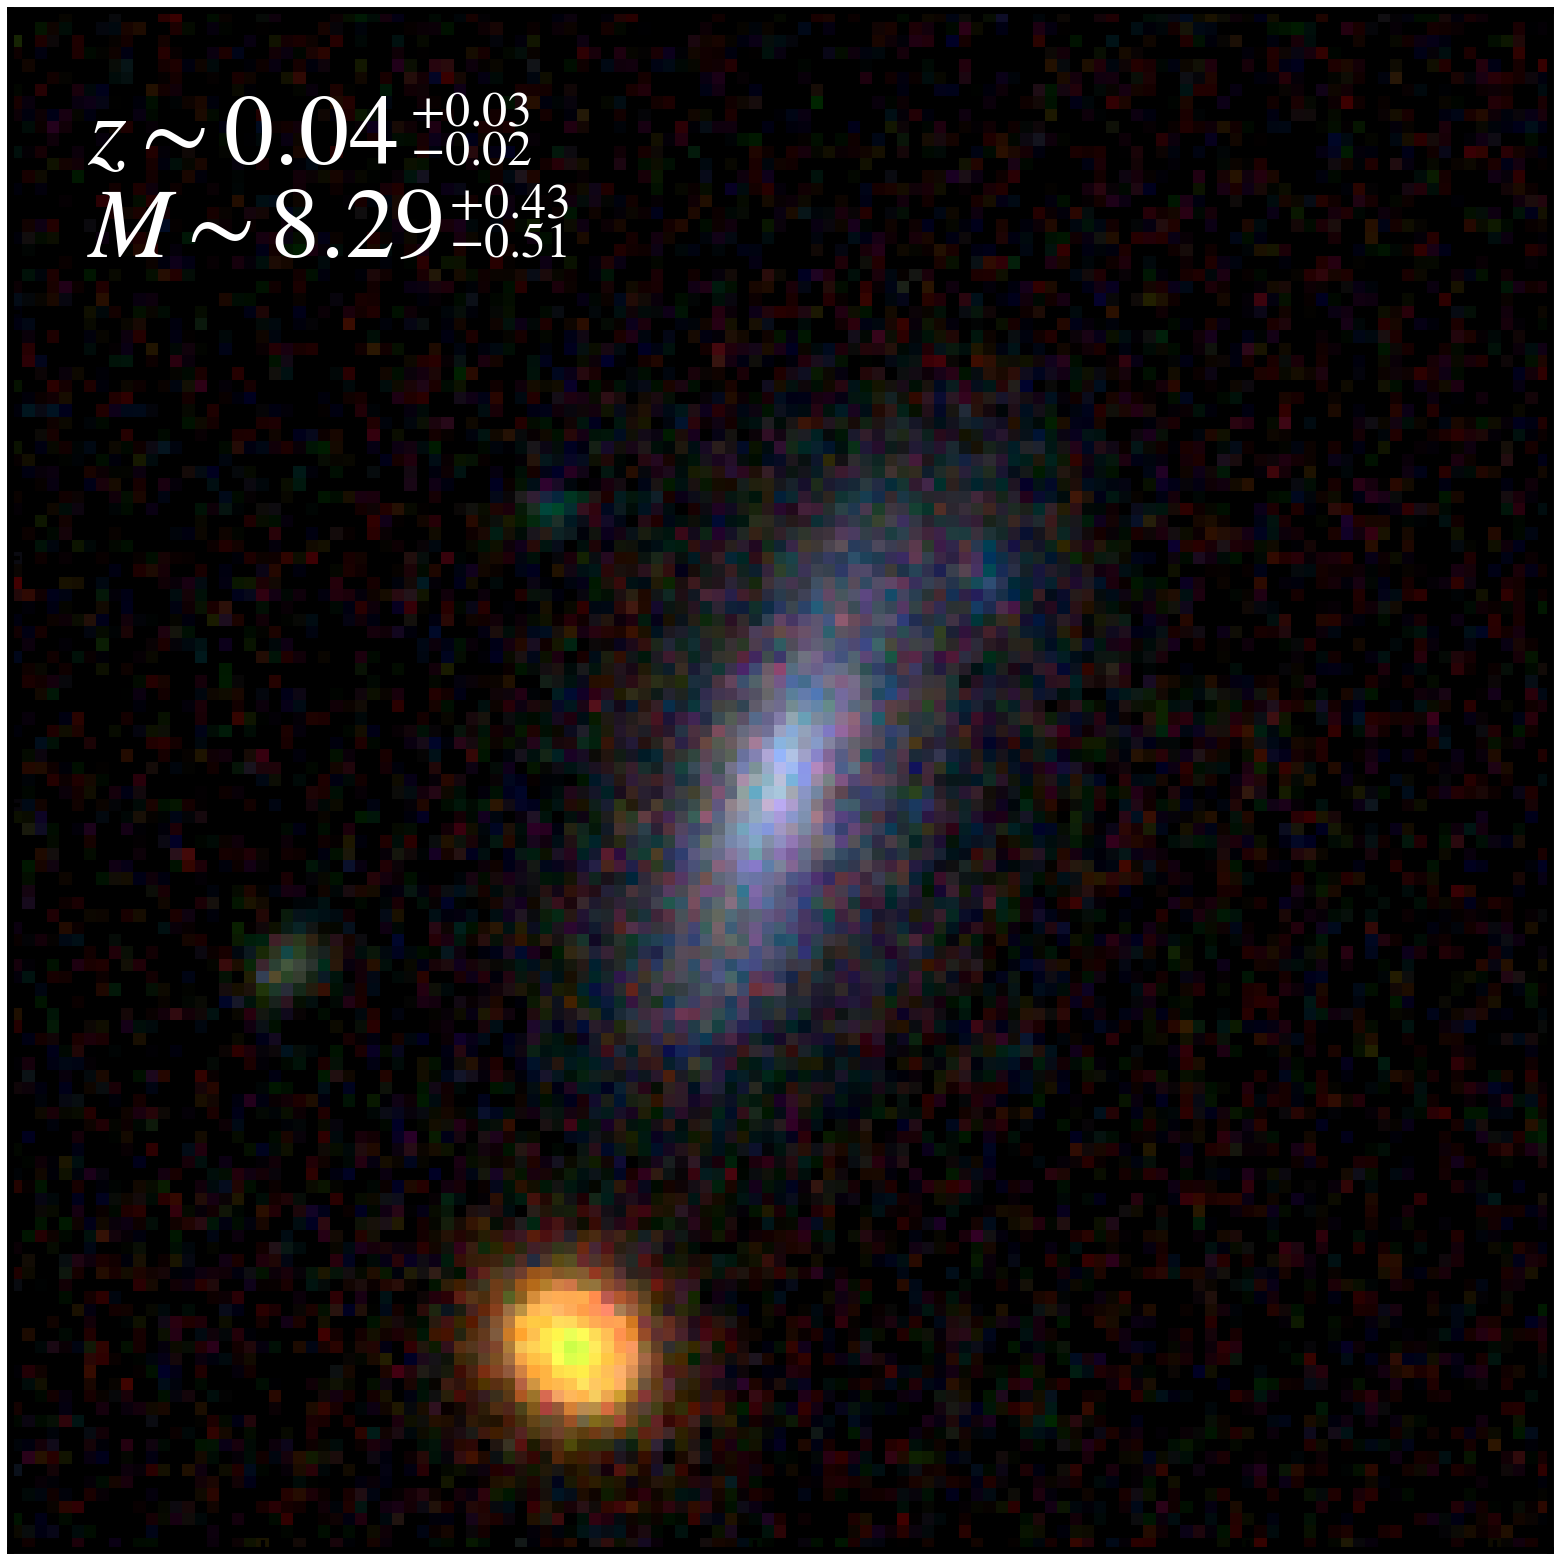

In [76]:
get_images_from_cell([32, 38], [1, 1], Q = 0.1, stretch = 0.2,
                     cutout_size = 25 * u.arcsec)

In [ ]:
predicted = False
while not predicted:
    rand_idx = np.random.randint(0, KiDS_predicted[1].get_nrows())
    source = KiDS_predicted[1][rand_idx]
    if not np.isnan(source['redshift_pred']): predicted = True

print(source)
plt.imshow(get_rgb_cutout(source['ra'] * u.deg, source['dec'] * u.deg,
                          source['KiDS_tile'], 10 * u.arcsec), origin = 'lower')

In [ ]:
cutout_size = 15

g_cutout = get_cutout(*(4.700388, -32.63908) * u.deg, cutout_size * u.arcsec,
                      g_image)
r_cutout = get_cutout(*(4.700388, -32.63908) * u.deg, cutout_size * u.arcsec,
                      r_image)
i_cutout = get_cutout(*(4.700388, -32.63908) * u.deg, cutout_size * u.arcsec,
                      i_image)

In [ ]:
def gauss(x, mu, sigma): return 1/(np.sqrt(2 * np.pi) * sigma) * np.exp(-(x - mu)**2/(2 * sigma**2))

In [ ]:
g_cutout_norm = g_cutout.copy()
g_cutout_norm /= g_cutout.std()

r_cutout_norm = r_cutout.copy()
r_cutout_norm /= r_cutout.std()

i_cutout_norm = i_cutout.copy()
i_cutout_norm /= i_cutout.std()

# g_cutout_norm -= np.min([g_cutout_norm.min(), r_cutout_norm.min(), i_cutout_norm.min()])
# r_cutout_norm -= np.min([g_cutout_norm.min(), r_cutout_norm.min(), i_cutout_norm.min()])
# i_cutout_norm -= np.min([g_cutout_norm.min(), r_cutout_norm.min(), i_cutout_norm.min()])

# g_cutout_norm /= np.max([g_cutout_norm.max(), r_cutout_norm.max(), i_cutout_norm.max()])
# r_cutout_norm /= np.max([g_cutout_norm.max(), r_cutout_norm.max(), i_cutout_norm.max()])
# i_cutout_norm /= np.max([g_cutout_norm.max(), r_cutout_norm.max(), i_cutout_norm.max()])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

ax.hist(g_cutout_norm[g_cutout_norm < 10].flatten(), bins = 'auto', histtype = 'step',
        edgecolor = 'blue', linewidth = 3)

ax.hist(r_cutout_norm[r_cutout_norm < 10].flatten(), bins = 'auto', histtype = 'step',
        edgecolor = 'green', linewidth = 3)

ax.hist(i_cutout_norm[i_cutout_norm < 10].flatten(), bins = 'auto', histtype = 'step',
        edgecolor = 'red', linewidth = 3)

In [ ]:
r_cutout_norm[r_cutout_norm < 4].std()

In [ ]:
# g_cutout_gray = g_cutout - np.min(g_cutout)
# g_cutout_gray /= np.max(g_cutout_gray)
# # g_cutout_gray *= 255

# r_cutout_gray = r_cutout - np.min(r_cutout)
# r_cutout_gray /= np.max(r_cutout_gray)
# # r_cutout_gray *= 255

# i_cutout_gray = i_cutout - np.min(i_cutout)
# i_cutout_gray /= np.max(i_cutout_gray)
# # i_cutout_gray *= 255

rgb_img = np.stack([i_cutout_norm,
                    r_cutout_norm,
                    g_cutout_norm], axis = -1)

In [ ]:
lupton_img = make_lupton_rgb(i_cutout_norm, r_cutout_norm, g_cutout_norm,
                             Q = 2, stretch = 1.5)

In [ ]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot()

ax.imshow(lupton_img, origin = 'lower')
ax.axis('off')

# fig.savefig('/home/lsajkov/Desktop/color_tile.pdf', dpi = 300, bbox_inches = 'tight')